<a href="https://colab.research.google.com/github/hsuanchia/Image-caption/blob/main/imgcap_0427.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json,re
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model,load_model
from keras.layers import LSTM,TimeDistributed,Dense,Embedding,Input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from PIL import Image 
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 匯入資料

In [ ]:
# Load Data
img_path = '/content/drive/MyDrive/MSCOCO_2017/val2017'
anno_path = '/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json'
input_file = open(anno_path)
annotation = json.load(input_file)

#處理 Caption data 

In [ ]:
# 處理caption: 全部都轉成小寫加上用regular expression刪掉標點符號
def preprocess(text):
  text = text.lower()
  tmp = re.split('\W+',text)
  return tmp

In [ ]:
start= "<start>"
end = "<end>"

In [ ]:
max_length = 30
tmp = ""
sentence = []
# 對所有的caption都做處理並加上start end 的 token
for x in annotation['annotations']:
  tmp = preprocess(x['caption'])
  tmp = " ".join(tmp)
  x['caption'] = start + " " + tmp + " " + end
  sentence.append(x['caption'])
# 做Tokenize

token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',num_words=10000,oov_tokens='<unk>') 
token.fit_on_texts(sentence)
word_index = token.word_index
word_index['<pad>'] = 0
inv_word_index = {v: k for k, v in word_index.items()}
voc_size = len(word_index) + 1 #從1開始算 所以總數要加1

In [ ]:
print(word_index)
print(inv_word_index)

{'a': 1, 'sss': 2, 'eee': 3, 'on': 4, 'of': 5, 'the': 6, 'in': 7, 'with': 8, 'and': 9, 'is': 10, 'to': 11, 'man': 12, 'sitting': 13, 'an': 14, 'two': 15, 'standing': 16, 'people': 17, 'at': 18, 'are': 19, 'next': 20, 'white': 21, 'woman': 22, 'street': 23, 'table': 24, 'that': 25, 'it': 26, 'holding': 27, 'large': 28, 'some': 29, 'person': 30, 'tennis': 31, 'top': 32, 'group': 33, 'up': 34, 'down': 35, 'field': 36, 'near': 37, 'train': 38, 'front': 39, 'black': 40, 'plate': 41, 'small': 42, 'cat': 43, 'his': 44, 'room': 45, 'riding': 46, 'dog': 47, 'red': 48, 'has': 49, 'by': 50, 'young': 51, 'playing': 52, 'water': 53, 'bus': 54, 'sign': 55, 'baseball': 56, 'food': 57, 'walking': 58, 'building': 59, 'bathroom': 60, 'side': 61, 'while': 62, 'green': 63, 'pizza': 64, 'blue': 65, 'grass': 66, 'looking': 67, 'there': 68, 'kitchen': 69, 'parked': 70, 'other': 71, 'for': 72, 'three': 73, 'city': 74, 'clock': 75, 'ball': 76, 'beach': 77, 'bed': 78, 'road': 79, 'toilet': 80, 'laptop': 81, 'ga

In [ ]:
print(annotation['annotations'][0])
print(annotation['images'][0])

{'image_id': 179765, 'id': 38, 'caption': 'sss a black honda motorcycle parked in front of a garage  eee'}
{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}


#處理圖片

In [ ]:
def load_image(path, size=None):
  """
  Load the image from the given file-path and resize it
  to the given size if not None.
  """
  # Load the image using PIL.
  img = Image.open(path)

  # Resize image if desired.
  img = img.resize(size=(224,224), resample=Image.LANCZOS)

  # Convert image to numpy array.
  img = np.array(img)

  # Scale image-pixels so they fall between 0.0 and 1.0
  img = img / 255.0

  # Convert 2-dim gray-scale array to 3-dim RGB array.
  if (len(img.shape) == 2):
      img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
  return img

#Encoder

In [ ]:
image_model = VGG16(include_top=True,weights='imagenet')
image_model.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
transfer_layer = image_model.get_layer('fc2')
encoder_model = Model(inputs=image_model.input,outputs=transfer_layer.output)
value_size = K.int_shape(transfer_layer.output)[1]

#Decoder

In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dense(256)(inputs1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(voc_size, 256, mask_zero=False)(inputs2)
se2 = LSTM(256,return_sequences=True,return_state=False,name='LSTM1')(se1,initial_state=[fe1,fe1])
#se3 = Dense(voc_size)(se2)
decode1 = TimeDistributed(Dense(voc_size, activation='softmax'))(se2)

model = Model(inputs=[inputs1, inputs2], outputs=decode1)
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
# summarize model
model.summary()
#plot_model(model, to_file='model_1.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 256)      1838592     input_5[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          1048832     input_4[0][0]                    
____________________________________________________________________________________________

#Data generator

In [ ]:
def data_generator(batch_num):
  x1, x2, y = list(), list(), list()
  n=0
  for cap in tqdm(annotation['annotations']):
    n += 1
    tmp = ""
    for x in range(12-len((str)(cap['image_id']))): #檔名為000000001234.jpg,前面補0後面加上image_id + .jpg
      tmp += "0"
    tmp += (str)(cap['image_id']) + ".jpg"
    tmp_path = img_path + '/' + tmp  
    img = load_image(tmp_path) #讀image
    #print(img)
    image_batch = np.expand_dims(img, axis=0) #要做predict還要再多1個dimension,請看encoder的input
    photo = encoder_model.predict(image_batch,verbose=0) 
    seq = [word_index[word] for word in cap['caption'].split(' ') if word in word_index]  #做斷詞並將詞轉成label
    
    in_seq, out_seq = seq[:-1], seq[1:] #ex. in_seq = [1,2,3,4,5] out_seq = [2,3,4,5]
    #做padding將句子用0補在後面補到max_length
    in_seq = pad_sequences([in_seq],maxlen=max_length,padding='post')[0]
    out_seq = pad_sequences([out_seq],maxlen=max_length,padding='post')[0]
    #out_seq = to_categorical([out_seq], num_classes=voc_size)[0] #因為output是機率分布，所以要再轉one-hot, dim=voc_size

    #print(in_seq,out_seq)
    x1.append(photo[0])
    x2.append(in_seq)
    y.append(out_seq)
    print(n,'/',batch_num)
    if n == batch_num:
      #print([np.array(x1), np.array(x2)], np.array(y))
      return ([np.array(x1), np.array(x2)], np.array(y)) 
      #return 就會是前batch_num筆資料
      #yield 就會是從上次for迴圈做到的地方繼續取batch_num筆資料

In [ ]:
trainx, trainy = data_generator(500)
#print(trainx)
#print(trainy)

1 / 500
2 / 500
3 / 500
4 / 500
5 / 500
6 / 500
7 / 500
8 / 500
9 / 500
10 / 500
11 / 500
12 / 500
13 / 500
14 / 500
15 / 500
16 / 500
17 / 500
18 / 500
19 / 500
20 / 500
21 / 500
22 / 500
23 / 500
24 / 500
25 / 500
26 / 500
27 / 500
28 / 500
29 / 500
30 / 500
31 / 500
32 / 500
33 / 500
34 / 500
35 / 500
36 / 500
37 / 500
38 / 500
39 / 500
40 / 500
41 / 500
42 / 500
43 / 500
44 / 500
45 / 500
46 / 500
47 / 500
48 / 500
49 / 500
50 / 500
51 / 500
52 / 500
53 / 500
54 / 500
55 / 500
56 / 500
57 / 500
58 / 500
59 / 500
60 / 500
61 / 500
62 / 500
63 / 500
64 / 500
65 / 500
66 / 500
67 / 500
68 / 500
69 / 500
70 / 500
71 / 500
72 / 500
73 / 500
74 / 500
75 / 500
76 / 500
77 / 500
78 / 500
79 / 500
80 / 500
81 / 500
82 / 500
83 / 500
84 / 500
85 / 500
86 / 500
87 / 500
88 / 500
89 / 500
90 / 500
91 / 500
92 / 500
93 / 500
94 / 500
95 / 500
96 / 500
97 / 500
98 / 500
99 / 500
100 / 500
101 / 500
102 / 500
103 / 500
104 / 500
105 / 500
106 / 500
107 / 500
108 / 500
109 / 500
110 / 500
111 / 50

# 訓練Model

In [ ]:
model.fit(trainx,trainy,epochs=100)

Epoch 1/100
16/16 [==============================] - 2s 41ms/step - loss: 7.7607 - sparse_categorical_accuracy: 0.5291
Epoch 2/100
16/16 [==============================] - 1s 32ms/step - loss: 2.5518 - sparse_categorical_accuracy: 0.6662
Epoch 3/100
16/16 [==============================] - 1s 33ms/step - loss: 2.0864 - sparse_categorical_accuracy: 0.6644
Epoch 4/100
16/16 [==============================] - 1s 33ms/step - loss: 2.0388 - sparse_categorical_accuracy: 0.6683
Epoch 5/100
16/16 [==============================] - 1s 33ms/step - loss: 2.0177 - sparse_categorical_accuracy: 0.6661
Epoch 6/100
16/16 [==============================] - 1s 34ms/step - loss: 1.9727 - sparse_categorical_accuracy: 0.6711
Epoch 7/100
16/16 [==============================] - 1s 32ms/step - loss: 1.9296 - sparse_categorical_accuracy: 0.6811
Epoch 8/100
16/16 [==============================] - 1s 33ms/step - loss: 1.8908 - sparse_categorical_accuracy: 0.6887
Epoch 9/100
16/16 [=============================

In [ ]:
model.save('/content/drive/MyDrive/MSCOCO_2017/model_noatt503.h5')

# 產生Caption

In [ ]:
def Generate_caption(img_path, show=True):
  decoder_model = load_model('/content/drive/MyDrive/MSCOCO_2017/model_noatt503.h5') #import你的model
  #這3行跟前面用encoder的地方一樣
  img = load_image(img_path)
  image_batch = np.expand_dims(img, axis=0)
  img_data = encoder_model.predict(image_batch,verbose=0)
  decoder_input = np.zeros((1,max_length,),dtype='float32') #input shape(batch number,30)
  token_cur = word_index[start] #現在的token, 初始為start token
  output_text = ''
  count_tokens = 0 #紀錄現在預測了幾個詞
  while token_cur != word_index[end] and count_tokens < max_length: #出現end token或是caption句子超過max_length就會停
    decoder_input[0,count_tokens] = token_cur #要將上一次預測的詞補到此次的input
    #print(decoder_input)
    decoder_output = decoder_model.predict([img_data,decoder_input])
    #print(decoder_output)

    token_cur = np.argmax(decoder_output[0,count_tokens]) #取機率分布最高值的index
    #print(token_cur)
    cur_word = inv_word_index[token_cur] #將label值map回到word
    if(cur_word != end and cur_word != start):
      output_text += " " + cur_word
    count_tokens += 1
  if show:
    test_image = plt.imread(img_path)
    plt.imshow(test_image)
    plt.show()
    print("Caption:")
    print(output_text)
    return output_text
  else:
    return output_text

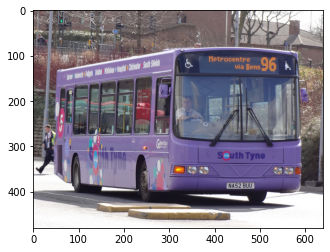

Caption:
 a large white and white and white and white and blue


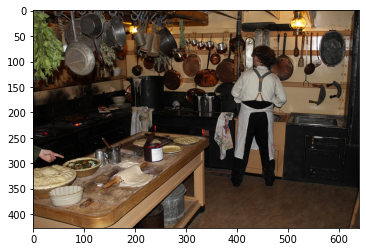

Caption:
 a bathroom with a big white and shower


' a bathroom with a big white and shower'

In [ ]:
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000002006.jpg')
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000397133.jpg')

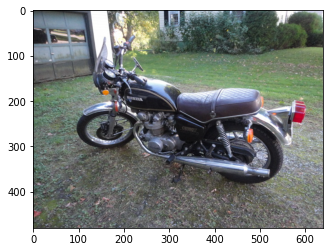

Caption:
 a motorcycle is parked in front of a garage


' a motorcycle is parked in front of a garage'

In [ ]:
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000179765.jpg')

# 評估模型準確度 Evaluate model
用來產生 BLEU, METEOR, ROUGE_L, CIDEr 分數

### 產生 validation set 的所有圖片的預測結果

In [ ]:
# 取得不重複的 val 圖片檔名列表
val_anno_path = '/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json'
input_file = open(anno_path)
val_annotation = json.load(input_file)

id_list = set()
for cap in val_annotation['annotations']:
  id_list.add(cap['image_id'])

id_list = list(id_list)

In [ ]:
len(id_list)

5000

In [ ]:
# 評分資料格式在 https://cocodataset.org/#format-data 的 5. Image Captioning 大標下有規定
results = list()
for id in tqdm(range(2696, len(id_list))):  # 多加個 tqdm 是為了看他印出漂亮的進度條
  one_result = dict()
  complete_path = img_path + '/%012d.jpg' % id_list[id]
  cap = Generate_caption(complete_path, False)
  one_result["image_id"] = id
  one_result["caption"] = cap
  results.append(one_result)


NameError: ignored

In [ ]:
len(results)

2695

In [ ]:
generated_caption_path = "generated_caption_val2017.json"
with open(generated_caption_path, 'w') as jsonfile:
  json.dump(results, jsonfile)

50331
/content/drive/MyDrive/MSCOCO_2017/val2017/000000050331.jpg


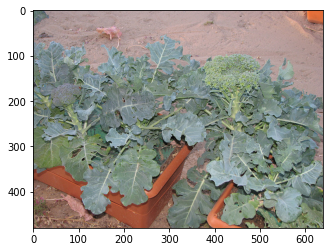

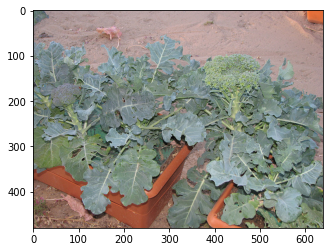

Caption:
 a motorcycle is parked on a field with a ticket
 a motorcycle is parked on a field with a ticket


In [ ]:
print(list(id_list)[2695])
complete_path = img_path + '/%012d.jpg' % list(id_list)[2695]
print(complete_path)
test_image = plt.imread(complete_path)
plt.imshow(test_image)
plt.show()
# 懷疑是某狀況會預測到 argmax 會取到 0，造成後面要取 inv_word_index[0] 出錯
cap = Generate_caption(complete_path, True)
print(cap)

In [ ]:
# 產生假的完美結果，測試用

'''
added_caps = set()
results = list()
for cap in annotation['annotations']:
  if cap['image_id'] not in added_caps:
    added_caps.add(cap['image_id'])
    one_result = dict()
    one_result["image_id"] = cap["image_id"]
    one_result["caption"] = cap["caption"]
    results.append(one_result)
  
generated_caption_path = "generated_caption_val2017.json"
with open(generated_caption_path, 'w') as jsonfile:
  json.dump(results, jsonfile)
'''

### coco-caption evaluation
從 GitHub 抓別人寫好的評分模組   
官方版是 tylin/coco-caption ，而 davidfsemedo 是相容 Python 3 的修改版本

In [ ]:
!git clone https://github.com/davidfsemedo/coco-caption


Cloning into 'coco-caption'...
remote: Enumerating objects: 737, done.
remote: Total 737 (delta 0), reused 0 (delta 0), pack-reused 737
Receiving objects: 100% (737/737), 106.72 MiB | 41.63 MiB/s, done.
Resolving deltas: 100% (400/400), done.


In [ ]:
import os, sys
sys.path.insert(0,"/content/coco-caption")

In [ ]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')


In [ ]:
#  workaround provided by https://github.com/tylin/coco-caption/issues/26#issuecomment-439825144
modified_anno_path = "/content/modified_captions_val2017.json"

with open(anno_path, 'r') as f:
    data = json.load(f)
    data['type'] = 'captions'
with open(modified_anno_path, 'w') as f:
    json.dump(data, f)

In [ ]:
coco = COCO(modified_anno_path)
cocoRes = coco.loadRes(generated_caption_path)

loading annotations into memory...
0:00:00.036594
creating index...
index created!
Loading and preparing results...     
DONE (t=0.01s)
creating index...
index created!


In [ ]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 28347, 'reflen': 27259, 'guess': [28347, 25652, 22957, 20262], 'correct': [11694, 2856, 710, 265]}
ratio: 1.0399134230895837
Bleu_1: 0.413
Bleu_2: 0.214
Bleu_3: 0.112
Bleu_4: 0.066
computing METEOR score...
METEOR: 0.104
computing Rouge score...
ROUGE_L: 0.320
computing CIDEr score...
CIDEr: 0.105


In [ ]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))

Bleu_1: 0.413
Bleu_2: 0.214
Bleu_3: 0.112
Bleu_4: 0.066
METEOR: 0.104
ROUGE_L: 0.320
CIDEr: 0.105
